In [64]:
!pip install matplotlib==3.4.0
!pip install transformers
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

### Wczytanie zbioru dla języka angielskiego - dane tylko z Twittera


In [66]:
df1 = pd.read_csv("/content/twitter_parsed_dataset.csv")
df2 = pd.read_csv("/content/twitter_sexism_parsed_dataset.csv")
df3 = pd.read_csv("/content/twitter_racism_parsed_dataset.csv")

df = pd.concat([df1, df2, df3])
df.head()
df

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [67]:
print("Ilość tweetów przed usunięciem duplikatów: ", df.shape[0])
df = df.drop_duplicates(subset=["index", "id"])
df = df.dropna()
print("Ilość tweetów po usunięciu duplikatów i nan: ", df.shape[0])

Ilość tweetów przed usunięciem duplikatów:  45203
Ilość tweetów po usunięciu duplikatów i nan:  30319


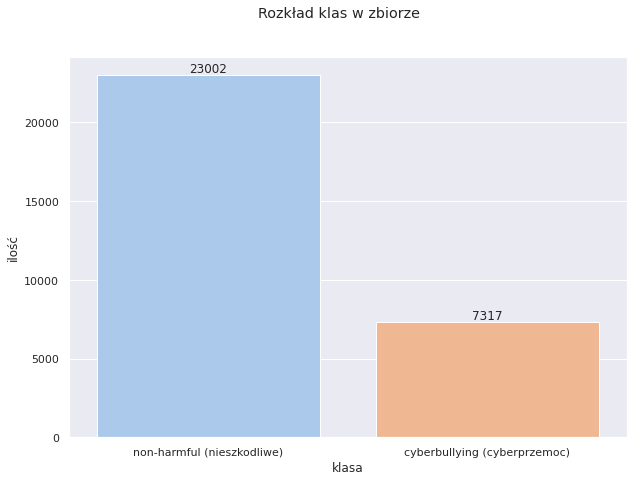

In [68]:
class_count = df.oh_label.value_counts()
sns.set(rc={'figure.figsize':(10,7)})
d = {'klasa': ['non-harmful (nieszkodliwe)', 'cyberbullying (cyberprzemoc)'], 'ilość': [class_count[0], class_count[1]]}
pd_for_barplot = pd.DataFrame(data=d)
ax = sns.barplot(data=pd_for_barplot, x="klasa", y="ilość", palette=sns.color_palette("pastel"))
ax.bar_label(ax.containers[0])
ax.figure.suptitle('Rozkład klas w zbiorze')
plt.savefig("Rozklad_klas_ang.png")

In [69]:
print("Procent tweetów dotyczących cyberprzemocy: ", (class_count[1] * 100)/(class_count[0] + class_count[1]), "%")

Procent tweetów dotyczących cyberprzemocy:  24.13338170783997 %


In [70]:
df = df[['Text', 'oh_label']]
df.head()

,Text,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0
4,#mkr No No No No No No,0.0


In [71]:
def cleaned_data(df):
  cleaned = []
  for text in df:
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(  r'@[^\s]*' ,'', text)
    text = re.sub(  r'http[^\s]*','', text)
    text = re.sub(  r'xd' ,'', text)
    text = re.sub(  r'XD' ,'', text)
    text = re.sub(  r'Xd' ,'', text)
    text = re.sub(  r'xD' ,'', text)
    text = re.sub(  r'#[^\s]*' ,'', text)
    text = re.sub(  r'\\"' ,'', text)
    text = text.replace('(', '')
    text = text.replace(')', '')
    text = text.replace(':', '')
    text = text.replace(';', '')
    text = text.replace('-', '')
    text = emoji_pattern.sub(r'', text)
    cleaned.append(text)
  return cleaned

df['text'] = cleaned_data(df['Text'])
df['label'] = df['oh_label']
df = df[['text', 'label']]
df.head()

,text,label
0,I read them in context.No change in meaning...,0.0
1,Now you idiots claim that people who tried to...,0.0
2,"RT Call me sexist, but when I go to an auto p...",1.0
3,"Wrong, ISIS follows the example of Mohammed a...",1.0
4,No No No No No No,0.0


**Podział zbioru**

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])
train_dataset = pd.DataFrame(data={'text': X_train, 'label': y_train})
test_dataset = pd.DataFrame(data={'text': X_test, 'label': y_test})
train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)
train_dataset.head()

,text,label
0,How to make Brown Butter Ice Cream with yoyom...,0.0
1,RT Is this Kara Lawson calling this game???? ...,1.0
2,"In fact, Morgan does not get it.",0.0
3,it is just short of paying my rent after all ...,0.0
4,I hate configuring retention policies and flus...,0.0


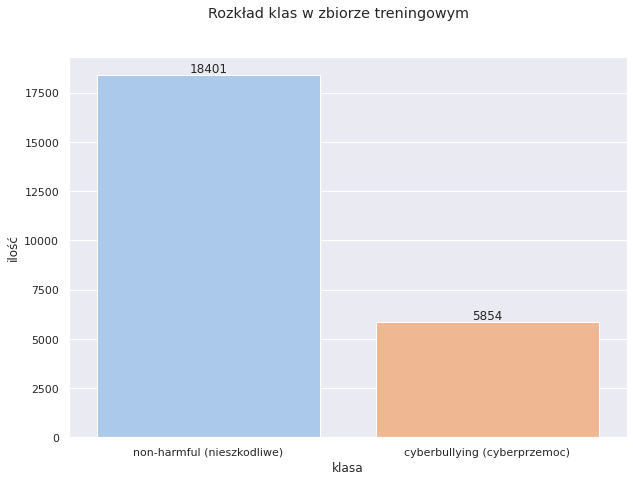

In [73]:
class_count = train_dataset.label.value_counts()
sns.set(rc={'figure.figsize':(10,7)})
d = {'klasa': ['non-harmful (nieszkodliwe)', 'cyberbullying (cyberprzemoc)'], 'ilość': [class_count[0], class_count[1]]}
pd_for_barplot = pd.DataFrame(data=d)
ax = sns.barplot(data=pd_for_barplot, x="klasa", y="ilość", palette=sns.color_palette("pastel"))
ax.bar_label(ax.containers[0])
ax.figure.suptitle('Rozkład klas w zbiorze treningowym')
plt.savefig("Rozklad_klas_ang_train.png")

In [74]:
print("Procent tweetów dotyczących cyberprzemocy dla zbioru treningowego: ", (class_count[1] * 100)/(class_count[0] + class_count[1]), "%")

Procent tweetów dotyczących cyberprzemocy dla zbioru treningowego:  24.135229849515564 %


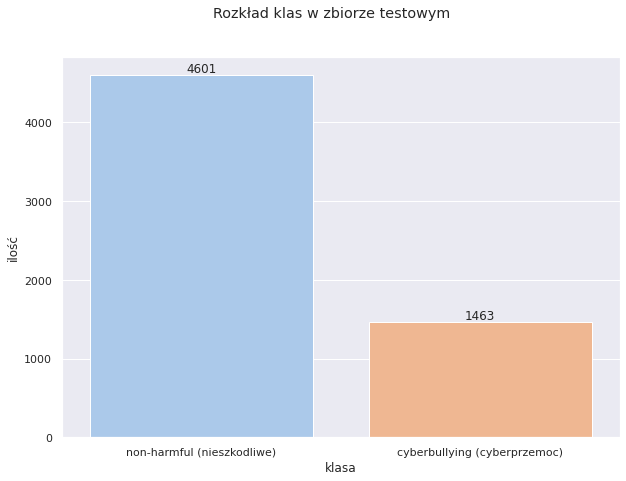

In [75]:
class_count = test_dataset.label.value_counts()
sns.set(rc={'figure.figsize':(10,7)})
d = {'klasa': ['non-harmful (nieszkodliwe)', 'cyberbullying (cyberprzemoc)'], 'ilość': [class_count[0], class_count[1]]}
pd_for_barplot = pd.DataFrame(data=d)
ax = sns.barplot(data=pd_for_barplot, x="klasa", y="ilość", palette=sns.color_palette("pastel"))
ax.bar_label(ax.containers[0])
ax.figure.suptitle('Rozkład klas w zbiorze testowym')
plt.savefig("Rozklad_klas_ang_test.png")

In [76]:
print("Procent tweetów dotyczących cyberprzemocy dla zbioru testowego: ", (class_count[1] * 100)/(class_count[0] + class_count[1]), "%")

Procent tweetów dotyczących cyberprzemocy dla zbioru testowego:  24.12598944591029 %


In [77]:
print("Rozmiar zbioru treningowego: ", train_dataset.shape[0])
print("Rozmiar zbioru testowego: ", test_dataset.shape[0])

Rozmiar zbioru treningowego:  24255
Rozmiar zbioru testowego:  6064


### Transfer wiedzy pomiędzy językami

In [78]:
#Tokenizer

tokenizer = BertTokenizer.from_pretrained('sentence-transformers/LaBSE')

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sentence-transformers--LaBSE/snapshots/931b5f9a111859fa72549cd1a7cb32168ebbe010/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--LaBSE/snapshots/931b5f9a111859fa72549cd1a7cb32168ebbe010/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--LaBSE/snapshots/931b5f9a111859fa72549cd1a7cb32168ebbe010/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--LaBSE/snapshots/931b5f9a111859fa72549cd1a7cb32168ebbe010/config.json
Model config BertConfig {
  "_name_or_path": "sentence-transformers/LaBSE",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradie

In [79]:
# Stworzenie datasetu

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels']=torch.tensor(self.labels[idx]).type(torch.LongTensor)
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(list(train_dataset['text']), truncation=True, max_length=None)
train_dataset = MyDataset(train_encodings, list(train_dataset['label']))

test_encodings = tokenizer(list(test_dataset['text']), truncation=True, max_length=None)
test_dataset = MyDataset(test_encodings, list(test_dataset['label']))

In [80]:
print(train_dataset)

In [81]:
# Model

bert_model = BertForSequenceClassification.from_pretrained('sentence-transformers/LaBSE', num_labels=2, problem_type="single_label_classification")
for param in bert_model.bert.parameters():
    param.requires_grad = False
bert_model.classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 384),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(384, 192),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(192, 2),
         ).cuda()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--LaBSE/snapshots/931b5f9a111859fa72549cd1a7cb32168ebbe010/config.json
Model config BertConfig {
  "_name_or_path": "old_models/LaBSE/0_Transformer",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_

In [82]:
# Trainer

from sklearn.metrics import accuracy_score, f1_score
from transformers import DataCollatorForLanguageModeling

def compute_metrics(pred):
    labels = pred.label_ids
    pred = pred.predictions.argmax(-1)
    # pred = torch.max(pred, 1)
    f1 = f1_score(labels, pred, average="micro")
    acc = accuracy_score(labels, pred)
    return {"accuracy": acc, "f1": f1}

data_collator = DataCollatorForLanguageModeling(tokenizer)

training_args = TrainingArguments(output_dir="test_trainer",
                                  num_train_epochs=5,
                                  evaluation_strategy = 'epoch',
                                  save_strategy = 'epoch',
                                  load_best_model_at_end=True,
                                  learning_rate=1e-3)


trainer = Trainer(
    bert_model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics = compute_metrics,
    tokenizer=tokenizer,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [83]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 24255
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15160
  Number of trainable parameters = 369602


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.331200,0.322201,0.867909,0.867909
2,0.298200,0.329557,0.880442,0.880442
3,0.223200,0.319257,0.894624,0.894624
4,0.140300,0.344949,0.906827,0.906827
5,0.085800,0.386484,0.916392,0.916392


***** Running Evaluation *****
  Num examples = 6064
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-3032
Configuration saved in test_trainer/checkpoint-3032/config.json
Model weights saved in test_trainer/checkpoint-3032/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-3032/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-3032/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 6064
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-6064
Configuration saved in test_trainer/checkpoint-6064/config.json
Model weights saved in test_trainer/checkpoint-6064/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-6064/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-6064/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 6064
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-9096
Configuration saved in tes

TrainOutput(global_step=15160, training_loss=0.22862174454339262, metrics={'train_runtime': 467.5007, 'train_samples_per_second': 259.411, 'train_steps_per_second': 32.428, 'total_flos': 1999797031536744.0, 'train_loss': 0.22862174454339262, 'epoch': 5.0})

In [84]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

***** Running Prediction *****
  Num examples = 6064
  Batch size = 8


(6064, 2) (6064,)


In [85]:
preds = np.argmax(predictions.predictions, axis=-1)

In [86]:
result = []

metric = evaluate.load("accuracy")
acc = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(['accuracy', acc['accuracy']])

metric = evaluate.load("f1")
f1 = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["f1", f1['f1']])

metric = evaluate.load("precision")
precision = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["precision", precision['precision']])

metric = evaluate.load("recall")
recall = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["recall", recall['recall']])

result = pd.DataFrame(data=result, columns=["metryka", "wynik"])
result



,metryka,wynik
0,accuracy,0.894624
1,f1,0.766533
2,precision,0.823391
3,recall,0.717020


### Przetestowanie dla PolEval

In [87]:
from datasets import load_dataset, concatenate_datasets

poleval_test = load_dataset("Nikutka/L1_poleval_korpus_pelny_test")
poleval_train = load_dataset("Nikutka/L1_poleval_korpus_pelny_train")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [88]:
test_encodings = tokenizer(list(poleval_test['train']['content']), truncation=True, max_length=None)
poleval_test = MyDataset(test_encodings, list(poleval_test['train']['label']))

In [89]:
predictions = trainer.predict(poleval_test)
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 891
  Batch size = 8


(891, 2) (891,)


In [90]:
result = []

metric = evaluate.load("accuracy")
acc = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(['accuracy', acc['accuracy']])

metric = evaluate.load("f1")
f1 = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["f1", f1['f1']])

metric = evaluate.load("precision")
precision = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["precision", precision['precision']])

metric = evaluate.load("recall")
recall = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["recall", recall['recall']])

result = pd.DataFrame(data=result, columns=["metryka", "wynik"])
result


,metryka,wynik
0,accuracy,0.931538
1,f1,0.089552
2,precision,0.071429
3,recall,0.120000


In [92]:
poleval_test = load_dataset("Nikutka/L1_poleval_korpus_pelny_test")
poleval_train = load_dataset("Nikutka/L1_poleval_korpus_pelny_train")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [93]:
poleval = concatenate_datasets([poleval_train['train'], poleval_test['train']])

In [94]:
poleval

Dataset({
    features: ['content', 'label'],
    num_rows: 10334
})

In [95]:
test_encodings = tokenizer(list(poleval['content']), truncation=True, max_length=None)
test_poleval = MyDataset(test_encodings, list(poleval['label']))

In [96]:
predictions = trainer.predict(test_poleval)
print(predictions.predictions.shape, predictions.label_ids.shape)

***** Running Prediction *****
  Num examples = 10334
  Batch size = 8


(10334, 2) (10334,)


In [97]:
preds = np.argmax(predictions.predictions, axis=-1)

In [98]:
result = []

metric = evaluate.load("accuracy")
acc = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(['accuracy', acc['accuracy']])

metric = evaluate.load("f1")
f1 = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["f1", f1['f1']])

metric = evaluate.load("precision")
precision = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["precision", precision['precision']])

metric = evaluate.load("recall")
recall = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["recall", recall['recall']])

result = pd.DataFrame(data=result, columns=["metryka", "wynik"])
result


,metryka,wynik
0,accuracy,0.927134
1,f1,0.089480
2,precision,0.067395
3,recall,0.133094


### Przetestowanie dla zbalansowanego zbioru poleval

In [99]:
 poleval['label'].count(1)

278

In [100]:
poleval['label'].count(0)

10056

In [101]:
i = 0
j = 0
 
poleval_ = []

for con, lab in zip(poleval['content'], poleval['label']):
  if lab == 0 and i < 275:
    poleval_.append([con, lab])
    i = i + 1
  elif lab == 1 and j < 275:
    poleval_.append([con, lab])
    j = j + 1
  elif i >= 275 and j >= 275:
    break

poleval_ = pd.DataFrame(data=poleval_, columns=["text", "label"])
print(poleval_.shape)
print(poleval_.head())

(550, 2)
                                                text  label
0  Dla mnie faworytem do tytułu będzie Cracovia. ...      0
1         Brawo ty Daria kibic ma być na dobre i złe      0
2    Super, polski premier składa kwiaty na groba...      0
3                        Musi. Innej drogi nie mamy.      0
4    Odrzut natychmiastowy, kwaśna mina, mam problem      0


In [102]:
test_encodings = tokenizer(list(poleval_['text']), truncation=True, max_length=None)
test_poleval_ = MyDataset(test_encodings, list(poleval_['label']))

predictions = trainer.predict(test_poleval_)
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 550
  Batch size = 8


(550, 2) (550,)


In [103]:
result = []

metric = evaluate.load("accuracy")
acc = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(['accuracy', acc['accuracy']])

metric = evaluate.load("f1")
f1 = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["f1", f1['f1']])

metric = evaluate.load("precision")
precision = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["precision", precision['precision']])

metric = evaluate.load("recall")
recall = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["recall", recall['recall']])

result = pd.DataFrame(data=result, columns=["metryka", "wynik"])
result


,metryka,wynik
0,accuracy,0.538182
1,f1,0.225610
2,precision,0.698113
3,recall,0.134545


### Przetestowanie dla zescrapowanego zbioru niezbalansowanego

In [104]:
scraped_test = load_dataset("Nikutka/L1_scraped_korpus_pelny_train")
scraped_train = load_dataset("Nikutka/L1_scraped_korpus_pelny_test")

scraped = concatenate_datasets([scraped_train['train'], scraped_test['train']])
scraped['label'].count(1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

36860

In [105]:
scraped

Dataset({
    features: ['content', 'label'],
    num_rows: 1561921
})

In [106]:
i = 0
j = 0
 
scraped_ = []

for con, lab in zip(scraped['content'], scraped['label']):
  if lab == 0 and i < 36850:
    scraped_.append([con, lab])
    i = i + 1
  elif lab == 1 and j < 36850:
    scraped_.append([con, lab])
    j = j + 1
  elif i >= 36850 and j >= 36850:
    break

scraped = pd.DataFrame(data=scraped_, columns=["text", "label"])
print(scraped.shape)
print(scraped.head())

(73700, 2)
                                                text  label
0   tez pan nawoływał do brania sztachet do ręki ...      0
1                       ej to nie tak mialo wygladac      0
2                                       Nicki Nicole      0
3                            um\n\nBARMY EM ORBITA\n      0
4                Poważnie tego traktować się nie da.      0


In [107]:

test_encodings = tokenizer(list(scraped['text']), truncation=True, max_length=None)
test_scraped= MyDataset(test_encodings, list(scraped['label']))

predictions = trainer.predict(test_scraped)
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

result = []

metric = evaluate.load("accuracy")
acc = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(['accuracy', acc['accuracy']])

metric = evaluate.load("f1")
f1 = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["f1", f1['f1']])

metric = evaluate.load("precision")
precision = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["precision", precision['precision']])

metric = evaluate.load("recall")
recall = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["recall", recall['recall']])

result = pd.DataFrame(data=result, columns=["metryka", "wynik"])
result

***** Running Prediction *****
  Num examples = 73700
  Batch size = 8


(73700, 2) (73700,)


,metryka,wynik
0,accuracy,0.527137
1,f1,0.219450
2,precision,0.628238
3,recall,0.132944


### Dotrenowanie modelu na zbiorze poleval i przetestowanie na polskich danych

In [108]:
poleval_train

DatasetDict({
    train: Dataset({
        features: ['content', 'label'],
        num_rows: 9443
    })
})

In [109]:
poleval_test

DatasetDict({
    train: Dataset({
        features: ['content', 'label'],
        num_rows: 891
    })
})

In [110]:
print(list(poleval_train['train']['label']).count(1))
print(list(poleval_train['train']['label']).count(0))

253
9190


In [111]:
print(list(poleval_test['train']['label']).count(1))
print(list(poleval_test['train']['label']).count(0))

25
866


In [112]:
train_encodings = tokenizer(list(poleval_train['train']['content']), truncation=True, max_length=None)
poleval_train = MyDataset(train_encodings, list(poleval_train['train']['label']))

In [113]:
test_encodings = tokenizer(list(poleval_test['train']['content']), truncation=True, max_length=None)
poleval_test = MyDataset(test_encodings, list(poleval_test['train']['label']))

In [114]:
trainer = Trainer(
    bert_model,
    training_args,
    train_dataset=poleval_train,
    eval_dataset=poleval_test,
    compute_metrics = compute_metrics,
    tokenizer=tokenizer,
)

In [115]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9443
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5905
  Number of trainable parameters = 369602


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.105300,0.112796,0.969697,0.969697
2,0.082200,0.120388,0.968575,0.968575
3,0.066800,0.154454,0.969697,0.969697
4,0.034100,0.216617,0.968575,0.968575
5,0.012100,0.256324,0.968575,0.968575


***** Running Evaluation *****
  Num examples = 891
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1181
Configuration saved in test_trainer/checkpoint-1181/config.json
Model weights saved in test_trainer/checkpoint-1181/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-1181/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-1181/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 891
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-2362
Configuration saved in test_trainer/checkpoint-2362/config.json
Model weights saved in test_trainer/checkpoint-2362/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-2362/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-2362/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 891
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-3543
Configuration saved in test_t

TrainOutput(global_step=5905, training_loss=0.06388615277942009, metrics={'train_runtime': 184.9492, 'train_samples_per_second': 255.286, 'train_steps_per_second': 31.928, 'total_flos': 790975158420876.0, 'train_loss': 0.06388615277942009, 'epoch': 5.0})

In [116]:
predictions = trainer.predict(poleval_test)
print(predictions.predictions.shape, predictions.label_ids.shape)
preds = np.argmax(predictions.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 891
  Batch size = 8


(891, 2) (891,)


In [117]:
result = []

metric = evaluate.load("accuracy")
acc = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(['accuracy', acc['accuracy']])

metric = evaluate.load("f1")
f1 = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["f1", f1['f1']])

metric = evaluate.load("precision")
precision = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["precision", precision['precision']])

metric = evaluate.load("recall")
recall = metric.compute(predictions=preds, references=predictions.label_ids)
result.append(["recall", recall['recall']])

result = pd.DataFrame(data=result, columns=["metryka", "wynik"])
result

,metryka,wynik
0,accuracy,0.969697
1,f1,0.129032
2,precision,0.333333
3,recall,0.080000
